# Introduction

Takes exploratory data and fits variations of the DDM.

DDM: average-signal

Details: Take every signal that the subject saw in a trial, and average their values. Feed that into a DDM as a time-invariant signal.

## Preamble

In [1]:
# Install (package verification, PyDDM, timer, parallelization)
#!pip install paranoid-scientist
#!pip install pyddm
#!pip install pytictoc  
#!pip install pathos  

In [2]:
# Libraries
import os
from pytictoc import TicToc
import csv
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import pyddm as ddm
from pyddm import Model, Sample, FitResult, Fittable, Fitted, ICPoint, set_N_cpus
from pyddm.models import NoiseConstant, BoundConstant, OverlayChain, OverlayNonDecision, OverlayUniformMixture, LossRobustBIC
from pyddm.functions import fit_adjust_model, display_model
import pyddm.plot

In [3]:
# Directories
datadir = "D:\\OneDrive - California Institute of Technology\\PhD\\Rangel Lab\\2023-common-consequence\\data\\processed_data"
ddmdir = "D:\\OneDrive - California Institute of Technology\\PhD\\Rangel Lab\\2023-common-consequence\\analysis\\outputs\\ddm"

In [4]:
# Parallel settings
ncpu = multiprocessing.cpu_count()-1 # always save one core
ncpu

11

## Import and Clean Raw Data

rawdata_in: odd trials used for in-sample data for model fitting.

rawdata_out: even trials used for out-sample data for model predictions.

In [5]:
# Import
data = pd.read_csv(datadir+"\\pilotdata.csv")

# Ceiling of Maximum RT for PyDDM
maxRT = math.ceil(max(data.rt))

# Display
data

,subject,trial,type,rt,p,r,vDiff_ab,choice_ab,vA,vB,choice_lr,H
0,9156482,1,AB,5.8416,0.5,0.7,5.25,1,30,24.75,1,45
1,9156482,2,AB,4.7081,0.5,0.7,-10.50,0,30,40.50,0,90
2,9156482,3,AB,4.2441,0.5,0.7,15.75,1,30,14.25,0,15
3,9156482,4,AB,5.2434,0.5,0.7,3.50,1,30,26.50,1,50
4,9156482,5,AB,2.6706,0.5,0.7,17.50,1,30,12.50,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...
1363,9158573,36,ApBp,1.2262,0.5,0.7,-1.50,0,9,10.50,0,50
1364,9158573,37,ApBp,1.2635,0.5,0.7,-12.00,0,9,21.00,1,100
1365,9158573,38,ApBp,0.9154,0.5,0.7,0.60,0,9,8.40,0,40
1366,9158573,39,ApBp,0.9328,0.5,0.7,-2.55,0,9,11.55,0,55


---
# DDM: Condition Invariant

## Fit the average stimulus DDM

In [6]:
# Create a drift subclass so drift can vary with stimulus.
class DriftRate(ddm.models.Drift):
  name = "Drift depends linearly on value difference"
  required_parameters = ["driftrate"] # Parameters we want to include in the model.
  required_conditions = ["vDiff_ab"] # The column in your sample data that modulates the parameters above.
  def get_drift(self, conditions, **kwargs):
    return self.driftrate * conditions["vDiff_ab"]

# Define the model.
model_ci = Model(name="Standard DDM that does not distinguish between AB and A'B' choices",
                 drift=DriftRate(driftrate=Fittable(minval=-1, maxval=1.5)),
                 noise=NoiseConstant(noise=Fittable(minval=.001, maxval=2)),
                 bound=BoundConstant(B=1),
                 IC=ICPoint(x0=Fittable(minval=-.99, maxval=.99)),
                 overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.1)),
                 dx=.01, dt=.01, T_dur=maxRT,  # dx: spatial grid for evidence space (-B to B, in dx bins), dt: time step in s. See Shin et al 2022 Fig 4 for why I set dx=dt.
                 choice_names=("A","B"))

In [7]:
# Interactive plot! Play with the variables!
vDiff_ab = np.sort(data.vDiff_ab.unique())
pyddm.plot.model_gui_jupyter(model=model_ci, conditions={"vDiff_ab":vDiff_ab.tolist()})

Output()

In [8]:
# Only run this if specified at the start. Otherwise, just load pre-saved weights.
print("DDM: Condition Invariant.")

# Iterate through subjects.
subnums = np.sort(data.subject.unique())
for subnum in subnums:

    # Progress tracker.
    print("=========================")
    print("Subject " + str(subnum))

    # Subset the data.
    subdata = data[data["subject"]==subnum]

    # Create a sample object from our data. Sample objects are the standard input for pyDDM fitting functions.
    ddm_data = Sample.from_pandas_dataframe(subdata, rt_column_name="rt", choice_column_name="choice_ab", choice_names=("A","B"))

    # Fit the model and show it off. Keep track of how long it took to estimate the parameters.
    clock = TicToc() # Timer
    clock.tic()
    set_N_cpus(ncpu) # Parallelize
    fit_model_ci = fit_adjust_model(sample=ddm_data, model=model_ci,
                                    fitting_method="differential_evolution",
                                    lossfunction=LossRobustBIC,
                                    verbose=False)
    clock.toc("Fitting subject " + str(subnum) + " took")
    display_model(fit_model_ci)

    # Save
    filename = ddmdir + "fit_model_ci_" + str(subnum) + ".txt"
    with open(filename, "w") as f:
      f.write(repr(fit_model_ci))

DDM: Condition Invariant.
Subject 9156374


Info: Params [ 0.05143956  0.35406125 -0.09954689  0.09418692] gave 197.61447647906212


Fitting subject 9156374 took 51.292450 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.051440
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.354061
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.099547
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.094187
Fit information:
    Loss function: BIC
    Loss function value: 197.61447647906212
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 40
        - mess: ''

Subject 9156482


Info: Params [0.01671458 0.42153983 0.17685222 0.09250859] gave 208.05003511220522


Fitting subject 9156482 took 61.347035 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.016715
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.421540
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.176852
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.092509
Fit information:
    Loss function: BIC
    Loss function value: 208.05003511220522
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 40
        - mess: ''

Subject 9156521


Info: Params [0.00601595 0.40064167 0.31494863 0.09406129] gave 235.3784155908062


Fitting subject 9156521 took 61.692536 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.006016
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.400642
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.314949
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.094061
Fit information:
    Loss function: BIC
    Loss function value: 235.3784155908062
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 39
        - mess: ''

Subject 9156545


Info: Params [0.02941073 0.25605716 0.01714437 0.09957119] gave 202.5906924813572


Fitting subject 9156545 took 53.284668 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.029411
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.256057
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.017144
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.099571 (WARNING: AT BOUNDARY)
Fit information:
    Loss function: BIC
    Loss function value: 202.5906924813572
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 39
        - mess: ''

Subject 9156644


Info: Params [ 0.00919122  0.4328665  -0.14977338  0.08683212] gave 244.17924876227102


Fitting subject 9156644 took 57.146645 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.009191
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.432866
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.149773
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.086832
Fit information:
    Loss function: BIC
    Loss function value: 244.17924876227102
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 39
        - mess: ''

Subject 9156653


Info: Params [ 0.04075622  0.53289362 -0.05056961  0.09062941] gave 199.17107358753307


Fitting subject 9156653 took 57.851953 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.040756
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.532894
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.050570
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.090629
Fit information:
    Loss function: BIC
    Loss function value: 199.17107358753307
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 40
        - mess: ''

Subject 9156665


Info: Params [0.02458427 0.65273858 0.33227095 0.00150875] gave 227.95736180182578


Fitting subject 9156665 took 73.160595 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.024584
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.652739
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.332271
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.001509
Fit information:
    Loss function: BIC
    Loss function value: 227.95736180182578
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 40
        - mess: ''

Subject 9156669


Info: Params [ 0.01712747  0.35954307 -0.00135499  0.09587814] gave 200.435388062215


Fitting subject 9156669 took 95.471452 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.017127
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.359543
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.001355
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.095878
Fit information:
    Loss function: BIC
    Loss function value: 200.435388062215
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 36
        - mess: ''

Subject 9156681


Info: Params [ 0.03458579  0.3700946  -0.20454788  0.08009958] gave 223.6510846752743


Fitting subject 9156681 took 79.770512 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.034586
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.370095
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.204548
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.080100
Fit information:
    Loss function: BIC
    Loss function value: 223.6510846752743
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 40
        - mess: ''

Subject 9156697


Info: Params [0.00995163 0.26774654 0.04423871 0.08469313] gave 198.42207807425652


Fitting subject 9156697 took 90.074775 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.009952
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.267747
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.044239
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.084693
Fit information:
    Loss function: BIC
    Loss function value: 198.42207807425652
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 35
        - mess: ''

Subject 9156707


Info: Params [ 0.01511841  0.52834057 -0.08045622  0.09047711] gave 214.03027096796745


Fitting subject 9156707 took 97.113364 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.015118
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.528341
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.080456
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.090477
Fit information:
    Loss function: BIC
    Loss function value: 214.03027096796745
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 39
        - mess: ''

Subject 9156713


Info: Params [0.04222503 0.46845813 0.10768628 0.09719239] gave 193.72917085073829


Fitting subject 9156713 took 84.507655 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.042225
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.468458
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.107686
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.097192
Fit information:
    Loss function: BIC
    Loss function value: 193.72917085073829
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 39
        - mess: ''

Subject 9156718


Info: Params [ 0.03929361  0.45722897 -0.12546502  0.09815322] gave 200.07694686689044


Fitting subject 9156718 took 110.514772 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.039294
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.457229
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.125465
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.098153
Fit information:
    Loss function: BIC
    Loss function value: 200.07694686689044
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 36
        - mess: ''

Subject 9156739


Info: Params [0.02004248 0.33520109 0.10615498 0.0923993 ] gave 176.3040622572313


Fitting subject 9156739 took 102.434607 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.020042
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.335201
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.106155
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.092399
Fit information:
    Loss function: BIC
    Loss function value: 176.3040622572313
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 40
        - mess: ''

Subject 9156742


Info: Params [ 0.04613361  0.31294976 -0.04135953  0.09149483] gave 171.51320812433423


Fitting subject 9156742 took 84.487053 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.046134
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.312950
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.041360
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.091495
Fit information:
    Loss function: BIC
    Loss function value: 171.51320812433423
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 33
        - mess: ''

Subject 9156769


Info: Params [ 0.02101293  0.42534878 -0.1657563   0.0941593 ] gave 205.73546666404505


Fitting subject 9156769 took 95.591164 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.021013
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.425349
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.165756
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.094159
Fit information:
    Loss function: BIC
    Loss function value: 205.73546666404505
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 40
        - mess: ''

Subject 9157153


Info: Params [ 0.02245008  0.29607153 -0.14610082  0.0964757 ] gave 191.0761823242403


Fitting subject 9157153 took 90.667551 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.022450
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.296072
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.146101
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.096476
Fit information:
    Loss function: BIC
    Loss function value: 191.0761823242403
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 39
        - mess: ''

Subject 9157156


Info: Params [0.00838149 0.18945848 0.1545333  0.08362615] gave 171.10618343073287


Fitting subject 9157156 took 98.352933 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.008381
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.189458
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.154533
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.083626
Fit information:
    Loss function: BIC
    Loss function value: 171.10618343073287
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 29
        - mess: ''

Subject 9157161


Info: Params [ 0.01175256  0.39251113 -0.2111378   0.09739844] gave 240.9410126463715


Fitting subject 9157161 took 83.613969 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.011753
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.392511
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.211138
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.097398
Fit information:
    Loss function: BIC
    Loss function value: 240.9410126463715
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 39
        - mess: ''

Subject 9157175


Info: Params [ 0.04692192  0.35587669 -0.30417606  0.09653188] gave 209.10448509067237


Fitting subject 9157175 took 99.166905 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.046922
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.355877
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.304176
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.096532
Fit information:
    Loss function: BIC
    Loss function value: 209.10448509067237
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 40
        - mess: ''

Subject 9157201


Info: Params [ 0.03045597  0.38674189 -0.16080597  0.099985  ] gave 190.49676806618876


Fitting subject 9157201 took 84.866326 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.030456
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.386742
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.160806
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.099985 (WARNING: AT BOUNDARY)
Fit information:
    Loss function: BIC
    Loss function value: 190.49676806618876
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 37
        - mess: ''

Subject 9157213


Info: Params [0.03705198 0.51263884 0.14517215 0.09794368] gave 194.26773229865378


Fitting subject 9157213 took 96.036494 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.037052
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.512639
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.145172
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.097944
Fit information:
    Loss function: BIC
    Loss function value: 194.26773229865378
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 40
        - mess: ''

Subject 9158390


Info: Params [ 0.03527774  0.34951406 -0.05298023  0.09998299] gave 198.01625866064887


Fitting subject 9158390 took 103.695400 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.035278
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.349514
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.052980
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.099983 (WARNING: AT BOUNDARY)
Fit information:
    Loss function: BIC
    Loss function value: 198.01625866064887
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 39
        - mess: ''

Subject 9158415


Info: Params [ 0.03777335  0.63410562 -0.2536284   0.09512809] gave 132.169091644649


Fitting subject 9158415 took 83.623149 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.037773
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.634106
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.253628
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.095128
Fit information:
    Loss function: BIC
    Loss function value: 132.169091644649
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 40
        - mess: ''

Subject 9158418


Info: Params [ 0.04657259  0.5373313  -0.20028559  0.09576298] gave 200.93744896324864


Fitting subject 9158418 took 90.730599 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.046573
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.537331
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.200286
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.095763
Fit information:
    Loss function: BIC
    Loss function value: 200.93744896324864
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 40
        - mess: ''

Subject 9158535


Info: Params [0.00560244 0.25733522 0.55828025 0.0992339 ] gave 228.5972962502556


Fitting subject 9158535 took 130.550256 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.005602
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.257335
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.558280
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.099234 (WARNING: AT BOUNDARY)
Fit information:
    Loss function: BIC
    Loss function value: 228.5972962502556
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 39
        - mess: ''

Subject 9158573


Info: Params [0.02291863 0.61740272 0.10803047 0.09810009] gave 195.92733594489826


Fitting subject 9158573 took 87.157594 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.022919
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.617403
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.108030
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.098100
Fit information:
    Loss function: BIC
    Loss function value: 195.92733594489826
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 40
        - mess: ''

Subject 9158588


Info: Params [ 0.01707166  0.33438456 -0.10816129  0.0833791 ] gave 219.79316886731283


Fitting subject 9158588 took 118.364940 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.017072
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.334385
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.108161
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.083379
Fit information:
    Loss function: BIC
    Loss function value: 219.79316886731283
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 39
        - mess: ''

Subject 9158742


Info: Params [ 0.01780517  0.39623903 -0.19603476  0.07741938] gave 199.33998752927212


Fitting subject 9158742 took 105.659930 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.017805
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.396239
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.196035
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.077419
Fit information:
    Loss function: BIC
    Loss function value: 199.33998752927212
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 36
        - mess: ''

Subject 9158775


Info: Params [ 0.01930543  0.40859693 -0.09373157  0.05755311] gave 219.0423882500663


Fitting subject 9158775 took 103.437364 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.019305
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.408597
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.093732
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.057553
Fit information:
    Loss function: BIC
    Loss function value: 219.0423882500663
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 39
        - mess: ''

Subject 9158881


Info: Params [0.03602609 0.28863499 0.26747856 0.05058009] gave 163.08524561623287


Fitting subject 9158881 took 142.387311 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.036026
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.288635
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.267479
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.050580
Fit information:
    Loss function: BIC
    Loss function value: 163.08524561623287
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 35
        - mess: ''

Subject 9158916


Info: Params [0.04780216 0.30418116 0.15347572 0.09084288] gave 168.5228967216496


Fitting subject 9158916 took 122.189879 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.047802
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.304181
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.153476
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.090843
Fit information:
    Loss function: BIC
    Loss function value: 168.5228967216496
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 39
        - mess: ''

Subject 9158924


Info: Params [0.01219398 0.29834574 0.12205554 0.07122265] gave 209.84388961087933


Fitting subject 9158924 took 124.513977 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.012194
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.298346
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.122056
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.071223
Fit information:
    Loss function: BIC
    Loss function value: 209.84388961087933
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 37
        - mess: ''

Subject 9161314


Info: Params [ 0.02198151  0.44772539 -0.10757277  0.09132845] gave 191.21463033259565


Fitting subject 9161314 took 106.272431 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.021982
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.447725
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.107573
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.091328
Fit information:
    Loss function: BIC
    Loss function value: 191.21463033259565
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 39
        - mess: ''

Subject 9163405


Info: Params [ 0.01691222  0.37804767 -0.06259372  0.06929596] gave 152.70769268636562


Fitting subject 9163405 took 92.323656 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.016912
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.378048
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.062594
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.069296
Fit information:
    Loss function: BIC
    Loss function value: 152.70769268636562
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 27
        - mess: ''

Subject 9163695


Info: Params [ 0.0386724   0.44275063 -0.29362081  0.08291547] gave 220.12502433882233


Fitting subject 9163695 took 118.949853 seconds.
Model Standard DDM that does not distinguish between AB and A'B' choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.038672
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.442751
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.293621
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.082915
Fit information:
    Loss function: BIC
    Loss function value: 220.12502433882233
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 40
        - mess: ''



## Extract parameters and BIC for the model objects

In [9]:
# Placeholders
model_ci_bic = []
model_ci_drift = []
model_ci_noise = []
model_ci_bias = []
model_ci_ndt = []

# Iterate through subjects.
subnums = np.sort(data.subject.unique())
for subnum in subnums:
    
    # Load
    filename = ddmdir + "fit_model_ci_" + str(subnum) + ".txt"
    with open(filename, "r") as f:
        model_loaded = eval(f.read())

    # Negative Log Likelihood.
    model_ci_bic.append(model_loaded.get_fit_result().value())
    
    # Fitted parameters.
    model_ci_drift.append(model_loaded.parameters()['drift']['driftrate'])
    model_ci_noise.append(model_loaded.parameters()['noise']['noise'])
    model_ci_bias.append(model_loaded.parameters()['IC']['x0'])
    model_ci_ndt.append(model_loaded.parameters()['overlay']['nondectime'])
    
d = {'bic':model_ci_bic, "drift":model_ci_drift, "noise":model_ci_noise, "bias":model_ci_bias, "ndt":model_ci_ndt}
indiv_model_ci = pd.DataFrame(data=d)
indiv_model_ci

,bic,drift,noise,bias,ndt
0,197.614476,0.051440,0.354061,-0.099547,0.094187
1,208.050035,0.016715,0.421540,0.176852,0.092509
2,235.378416,0.006016,0.400642,0.314949,0.094061
3,202.590692,0.029411,0.256057,0.017144,0.099571
4,244.179249,0.009191,0.432866,-0.149773,0.086832
5,199.171074,0.040756,0.532894,-0.050570,0.090629
6,227.957362,0.024584,0.652739,0.332271,0.001509
7,200.435388,0.017127,0.359543,-0.001355,0.095878
8,223.651085,0.034586,0.370095,-0.204548,0.080100
9,198.422078,0.009952,0.267747,0.044239,0.084693


## Means of BIC and Estimates

Confidence intervals assume normal distribution.

In [10]:
summstats_model_ci = pd.DataFrame(data={"mean":indiv_model_ci.mean(), 
                                        "se":indiv_model_ci.sem(),
                                        "ci_lower":indiv_model_ci.mean()-1.96*indiv_model_ci.sem(),
                                        "ci_upper":indiv_model_ci.mean()+1.96*indiv_model_ci.sem()}).T
summstats_model_ci

,bic,drift,noise,bias,ndt
mean,199.865381,0.026570,0.400100,-0.013926,0.086626
se,4.026436,0.002265,0.018203,0.032338,0.003107
ci_lower,191.973566,0.022130,0.364422,-0.077308,0.080537
ci_upper,207.757195,0.031010,0.435778,0.049456,0.092716


---
# DDM: Separately by Block (p,r)

## Separate datasets by type (AB or ApBp)

In [11]:
data_ab = data[data.type=="AB"]
data_apbp = data[data.type=="ApBp"]

print(data_ab.head(2))
print(data_ab.head(2))

   subject  trial type      rt    p    r  vDiff_ab  choice_ab  vA     vB  \
0  9156482      1   AB  5.8416  0.5  0.7      5.25          1  30  24.75   
1  9156482      2   AB  4.7081  0.5  0.7    -10.50          0  30  40.50   

   choice_lr   H  
0          1  45  
1          0  90  
   subject  trial type      rt    p    r  vDiff_ab  choice_ab  vA     vB  \
0  9156482      1   AB  5.8416  0.5  0.7      5.25          1  30  24.75   
1  9156482      2   AB  4.7081  0.5  0.7    -10.50          0  30  40.50   

   choice_lr   H  
0          1  45  
1          0  90  


## Generate DDM Model

In [12]:
# Create a drift subclass so drift can vary with stimulus.
class DriftRate(ddm.models.Drift):
  name = "Drift depends linearly on value difference"
  required_parameters = ["driftrate"] # Parameters we want to include in the model.
  required_conditions = ["vDiff_ab"] # The column in your sample data that modulates the parameters above.
  def get_drift(self, conditions, **kwargs):
    return self.driftrate * conditions["vDiff_ab"]

# Define the model.
model_ab = Model(name="Standard DDM fit to AB choices",
                 drift=DriftRate(driftrate=Fittable(minval=-1, maxval=1.5)),
                 noise=NoiseConstant(noise=Fittable(minval=.001, maxval=2)),
                 bound=BoundConstant(B=1),
                 IC=ICPoint(x0=Fittable(minval=-.99, maxval=.99)),
                 overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.1)),
                 dx=.01, dt=.01, T_dur=maxRT,  # dx: spatial grid for evidence space (-B to B, in dx bins), dt: time step in s. See Shin et al 2022 Fig 4 for why I set dx=dt.
                 choice_names=("A","B"))

model_apbp = Model(name="Standard DDM fit to ApBp choices",
                 drift=DriftRate(driftrate=Fittable(minval=-1, maxval=1.5)),
                 noise=NoiseConstant(noise=Fittable(minval=.001, maxval=2)),
                 bound=BoundConstant(B=1),
                 IC=ICPoint(x0=Fittable(minval=-.99, maxval=.99)),
                 overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.1)),
                 dx=.01, dt=.01, T_dur=maxRT,  # dx: spatial grid for evidence space (-B to B, in dx bins), dt: time step in s. See Shin et al 2022 Fig 4 for why I set dx=dt.
                 choice_names=("A","B"))

In [13]:
# Only run this if specified at the start. Otherwise, just load pre-saved weights.
print("DDM: AB.")

# Iterate through subjects.
subnums = np.sort(data_ab.subject.unique())
for subnum in subnums:

    # Progress tracker.
    print("=========================")
    print("Subject " + str(subnum))

    # Subset the data.
    subdata = data_ab[data_ab["subject"]==subnum]

    # Create a sample object from our data. Sample objects are the standard input for pyDDM fitting functions.
    ddm_data = Sample.from_pandas_dataframe(subdata, rt_column_name="rt", choice_column_name="choice_ab", choice_names=("A","B"))

    # Fit the model and show it off. Keep track of how long it took to estimate the parameters.
    clock = TicToc() # Timer
    clock.tic()
    set_N_cpus(ncpu) # Parallelize
    fit_model_ab = fit_adjust_model(sample=ddm_data, model=model_ab,
                                    fitting_method="differential_evolution",
                                    lossfunction=LossRobustBIC,
                                    verbose=False)
    clock.toc("Fitting subject " + str(subnum) + " took")
    display_model(fit_model_ab)

    # Save
    filename = ddmdir + "fit_model_ab_" + str(subnum) + ".txt"
    with open(filename, "w") as f:
      f.write(repr(fit_model_ab))

DDM: AB.
Subject 9156374


Info: Params [ 0.05878343  0.31390436 -0.16594181  0.06714619] gave 97.31266019360497


Fitting subject 9156374 took 115.330645 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.058783
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.313904
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.165942
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.067146
Fit information:
    Loss function: BIC
    Loss function value: 97.31266019360497
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156482


Info: Params [0.01800666 0.40190056 0.20184972 0.09872463] gave 106.88761193884659


Fitting subject 9156482 took 115.689820 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.018007
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.401901
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.201850
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.098725
Fit information:
    Loss function: BIC
    Loss function value: 106.88761193884659
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156521


Info: Params [0.01251521 0.30136123 0.25089687 0.07461617] gave 116.77822790651278


Fitting subject 9156521 took 137.201356 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.012515
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.301361
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.250897
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.074616
Fit information:
    Loss function: BIC
    Loss function value: 116.77822790651278
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156545


Info: Params [0.03125532 0.24542206 0.10672131 0.07887524] gave 104.90997226722592


Fitting subject 9156545 took 112.090237 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.031255
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.245422
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.106721
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.078875
Fit information:
    Loss function: BIC
    Loss function value: 104.90997226722592
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156644


Info: Params [ 0.00142741  0.39287787 -0.32481465  0.09266146] gave 125.13055789723788


Fitting subject 9156644 took 112.529365 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.001427
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.392878
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.324815
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.092661
Fit information:
    Loss function: BIC
    Loss function value: 125.13055789723788
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 19
        - mess: ''

Subject 9156653


Info: Params [ 0.05846042  0.56171942 -0.10466044  0.08022145] gave 95.99543157706401


Fitting subject 9156653 took 111.932166 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.058460
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.561719
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.104660
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.080221
Fit information:
    Loss function: BIC
    Loss function value: 95.99543157706401
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156665


Info: Params [0.01953751 0.54220248 0.36978143 0.00440017] gave 123.1852620627078


Fitting subject 9156665 took 112.081384 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.019538
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.542202
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.369781
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.004400
Fit information:
    Loss function: BIC
    Loss function value: 123.1852620627078
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156669


Info: Params [ 0.01544826  0.28340479 -0.24827688  0.0985199 ] gave 102.62066209856724


Fitting subject 9156669 took 118.829862 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.015448
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.283405
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.248277
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.098520
Fit information:
    Loss function: BIC
    Loss function value: 102.62066209856724
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 18
        - mess: ''

Subject 9156681


Info: Params [ 0.03326229  0.36444965 -0.15873051  0.08154237] gave 118.13251424398071


Fitting subject 9156681 took 102.138127 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.033262
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.364450
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.158731
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.081542
Fit information:
    Loss function: BIC
    Loss function value: 118.13251424398071
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156697


Info: Params [0.01147295 0.31070203 0.02645707 0.09370741] gave 101.68204753465082


Fitting subject 9156697 took 122.051039 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.011473
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.310702
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.026457
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.093707
Fit information:
    Loss function: BIC
    Loss function value: 101.68204753465082
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 18
        - mess: ''

Subject 9156707


Info: Params [ 0.00595332  0.4756218  -0.13699182  0.06114936] gave 124.76057472288718


Fitting subject 9156707 took 118.479316 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.005953
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.475622
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.136992
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.061149
Fit information:
    Loss function: BIC
    Loss function value: 124.76057472288718
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 19
        - mess: ''

Subject 9156713


Info: Params [0.04031049 0.47107233 0.13996024 0.0935654 ] gave 98.55626895307356


Fitting subject 9156713 took 114.061953 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.040310
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.471072
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.139960
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.093565
Fit information:
    Loss function: BIC
    Loss function value: 98.55626895307356
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 19
        - mess: ''

Subject 9156718


Info: Params [ 0.04311851  0.46200354 -0.11085121  0.09509931] gave 90.51821939865042


Fitting subject 9156718 took 99.393313 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.043119
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.462004
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.110851
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.095099
Fit information:
    Loss function: BIC
    Loss function value: 90.51821939865042
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 16
        - mess: ''

Subject 9156739


Info: Params [0.01687724 0.34450166 0.1516422  0.0985468 ] gave 101.16066016554934


Fitting subject 9156739 took 147.603672 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.016877
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.344502
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.151642
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.098547
Fit information:
    Loss function: BIC
    Loss function value: 101.16066016554934
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156742


Info: Params [ 0.06256845  0.3358895  -0.02002316  0.09324601] gave 73.35655979355633


Fitting subject 9156742 took 98.154550 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.062568
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.335889
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.020023
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.093246
Fit information:
    Loss function: BIC
    Loss function value: 73.35655979355633
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 15
        - mess: ''

Subject 9156769


Info: Params [ 0.01810959  0.44028889 -0.28425435  0.09097077] gave 105.26264447982429


Fitting subject 9156769 took 129.990243 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.018110
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.440289
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.284254
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.090971
Fit information:
    Loss function: BIC
    Loss function value: 105.26264447982429
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9157153


Info: Params [ 0.02245599  0.3070224  -0.23524333  0.09116689] gave 104.6011630938022


Fitting subject 9157153 took 137.496420 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.022456
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.307022
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.235243
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.091167
Fit information:
    Loss function: BIC
    Loss function value: 104.6011630938022
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9157156


Info: Params [0.00933432 0.19871043 0.08832567 0.08575216] gave 101.47204367707113


Fitting subject 9157156 took 144.380432 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.009334
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.198710
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.088326
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.085752
Fit information:
    Loss function: BIC
    Loss function value: 101.47204367707113
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 17
        - mess: ''

Subject 9157161


Info: Params [ 0.00619957  0.42341907 -0.08455974  0.09811677] gave 132.29928685485422


Fitting subject 9157161 took 144.269076 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.006200
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.423419
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.084560
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.098117
Fit information:
    Loss function: BIC
    Loss function value: 132.29928685485422
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9157175


Info: Params [ 0.04830374  0.30880188 -0.45418466  0.09783733] gave 107.62103572055658


Fitting subject 9157175 took 153.769874 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.048304
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.308802
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.454185
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.097837
Fit information:
    Loss function: BIC
    Loss function value: 107.62103572055658
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9157201


Info: Params [ 0.02854216  0.42867618 -0.079358    0.09661553] gave 99.62638668709337


Fitting subject 9157201 took 147.077424 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.028542
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.428676
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.079358
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.096616
Fit information:
    Loss function: BIC
    Loss function value: 99.62638668709337
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 18
        - mess: ''

Subject 9157213


Info: Params [ 0.05700869  0.47527628 -0.0023639   0.0906069 ] gave 98.45195359519353


Fitting subject 9157213 took 10903.319947 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.057009
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.475276
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.002364
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.090607
Fit information:
    Loss function: BIC
    Loss function value: 98.45195359519353
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9158390


Info: Params [ 0.04219954  0.35131107 -0.02183966  0.08047647] gave 95.89677219756346


Fitting subject 9158390 took 69.619048 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.042200
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.351311
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.021840
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.080476
Fit information:
    Loss function: BIC
    Loss function value: 95.89677219756346
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9158415


Info: Params [ 0.03426662  0.49398989 -0.40498875  0.09932458] gave 73.57998645233144


Fitting subject 9158415 took 58.191218 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.034267
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.493990
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.404989
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.099325 (WARNING: AT BOUNDARY)
Fit information:
    Loss function: BIC
    Loss function value: 73.57998645233144
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9158418


Info: Params [ 0.02461466  0.53455836 -0.08347017  0.09318657] gave 111.71005987017647


Fitting subject 9158418 took 49.116817 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.024615
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.534558
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.083470
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.093187
Fit information:
    Loss function: BIC
    Loss function value: 111.71005987017647
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9158535


Info: Params [0.00473974 0.20989668 0.58986024 0.05551914] gave 129.3203106530054


Fitting subject 9158535 took 51.975025 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.004740
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.209897
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.589860
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.055519
Fit information:
    Loss function: BIC
    Loss function value: 129.3203106530054
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9158573


Info: Params [0.00965898 0.58144303 0.35212455 0.09400276] gave 91.65015959802234


Fitting subject 9158573 took 48.447785 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.009659
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.581443
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.352125
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.094003
Fit information:
    Loss function: BIC
    Loss function value: 91.65015959802234
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9158588


Info: Params [ 0.01868371  0.36140207 -0.13562042  0.0653376 ] gave 111.82156198088059


Fitting subject 9158588 took 51.877225 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.018684
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.361402
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.135620
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.065338
Fit information:
    Loss function: BIC
    Loss function value: 111.82156198088059
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9158742


Info: Params [ 0.02058053  0.38294491 -0.35539406  0.09426855] gave 101.2241731464132


Fitting subject 9158742 took 58.744009 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.020581
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.382945
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.355394
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.094269
Fit information:
    Loss function: BIC
    Loss function value: 101.2241731464132
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 19
        - mess: ''

Subject 9158775


Info: Params [ 0.01634151  0.38020376 -0.00854773  0.0730588 ] gave 118.94881886561205


Fitting subject 9158775 took 57.993425 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.016342
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.380204
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.008548
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.073059
Fit information:
    Loss function: BIC
    Loss function value: 118.94881886561205
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9158881


Info: Params [0.02723591 0.2555751  0.32010521 0.09564318] gave 93.5574024991589


Fitting subject 9158881 took 59.893823 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.027236
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.255575
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.320105
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.095643
Fit information:
    Loss function: BIC
    Loss function value: 93.5574024991589
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 18
        - mess: ''

Subject 9158916


Info: Params [0.04733667 0.29353755 0.14637396 0.09794526] gave 89.60800093715557


Fitting subject 9158916 took 50.560116 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.047337
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.293538
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.146374
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.097945
Fit information:
    Loss function: BIC
    Loss function value: 89.60800093715557
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9158924


Info: Params [0.01574307 0.26002333 0.10929071 0.08170637] gave 94.0621516417786


Fitting subject 9158924 took 64.330789 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.015743
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.260023
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.109291
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.081706
Fit information:
    Loss function: BIC
    Loss function value: 94.0621516417786
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 18
        - mess: ''

Subject 9161314


Info: Params [ 0.02381023  0.4007494  -0.26136909  0.0827341 ] gave 104.59699359357072


Fitting subject 9161314 took 63.451944 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.023810
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.400749
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.261369
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.082734
Fit information:
    Loss function: BIC
    Loss function value: 104.59699359357072
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9163405


Info: Params [ 0.01426972  0.38507233 -0.12523782  0.07395703] gave 82.80951272764483


Fitting subject 9163405 took 38.453505 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.014270
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.385072
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.125238
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.073957
Fit information:
    Loss function: BIC
    Loss function value: 82.80951272764483
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 13
        - mess: ''

Subject 9163695


Info: Params [ 0.05392036  0.45257101 -0.3876314   0.09832782] gave 104.70171906986384


Fitting subject 9163695 took 48.420378 seconds.
Model Standard DDM fit to AB choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.053920
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.452571
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.387631
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.098328
Fit information:
    Loss function: BIC
    Loss function value: 104.70171906986384
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''



In [14]:
# Only run this if specified at the start. Otherwise, just load pre-saved weights.
print("DDM: ApBp.")

# Iterate through subjects.
subnums = np.sort(data_apbp.subject.unique())
for subnum in subnums:

    # Progress tracker.
    print("=========================")
    print("Subject " + str(subnum))

    # Subset the data.
    subdata = data_apbp[data_apbp["subject"]==subnum]

    # Create a sample object from our data. Sample objects are the standard input for pyDDM fitting functions.
    ddm_data = Sample.from_pandas_dataframe(subdata, rt_column_name="rt", choice_column_name="choice_ab", choice_names=("A","B"))

    # Fit the model and show it off. Keep track of how long it took to estimate the parameters.
    clock = TicToc() # Timer
    clock.tic()
    set_N_cpus(ncpu) # Parallelize
    fit_model_apbp = fit_adjust_model(sample=ddm_data, model=model_apbp,
                                    fitting_method="differential_evolution",
                                    lossfunction=LossRobustBIC,
                                    verbose=False)
    clock.toc("Fitting subject " + str(subnum) + " took")
    display_model(fit_model_apbp)

    # Save
    filename = ddmdir + "fit_model_apbp_" + str(subnum) + ".txt"
    with open(filename, "w") as f:
      f.write(repr(fit_model_apbp))

DDM: ApBp.
Subject 9156374


Info: Params [ 0.04531221  0.36777399 -0.04811825  0.09954139] gave 108.01053188244744


Fitting subject 9156374 took 56.239898 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.045312
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.367774
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.048118
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.099541 (WARNING: AT BOUNDARY)
Fit information:
    Loss function: BIC
    Loss function value: 108.01053188244744
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156482


Info: Params [0.01532195 0.4357253  0.1783349  0.09809259] gave 110.05484316778711


Fitting subject 9156482 took 45.978720 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.015322
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.435725
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.178335
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.098093
Fit information:
    Loss function: BIC
    Loss function value: 110.05484316778711
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156521


Info: Params [-0.00127913  0.42158276  0.34051868  0.09015106] gave 110.85833384623379


Fitting subject 9156521 took 58.390506 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: -0.001279
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.421583
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.340519
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.090151
Fit information:
    Loss function: BIC
    Loss function value: 110.85833384623379
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 19
        - mess: ''

Subject 9156545


Info: Params [0.02834941 0.26884858 0.0095111  0.0923759 ] gave 106.60512727887075


Fitting subject 9156545 took 55.910343 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.028349
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.268849
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.009511
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.092376
Fit information:
    Loss function: BIC
    Loss function value: 106.60512727887075
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 19
        - mess: ''

Subject 9156644


Info: Params [ 0.02882861  0.3349064  -0.26536931  0.06380235] gave 102.64234531978087


Fitting subject 9156644 took 53.652663 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.028829
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.334906
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.265369
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.063802
Fit information:
    Loss function: BIC
    Loss function value: 102.64234531978087
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156653


Info: Params [ 0.03792175  0.49814217 -0.18397238  0.09720895] gave 110.16350468686542


Fitting subject 9156653 took 52.739620 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.037922
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.498142
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.183972
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.097209
Fit information:
    Loss function: BIC
    Loss function value: 110.16350468686542
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156665


Info: Params [0.03810344 0.79434321 0.29153314 0.00633134] gave 102.62523808447054


Fitting subject 9156665 took 117.547492 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.038103
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.794343
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.291533
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.006331
Fit information:
    Loss function: BIC
    Loss function value: 102.62523808447054
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156669


Info: Params [0.02051714 0.32595908 0.24209545 0.09305445] gave 95.90918322301705


Fitting subject 9156669 took 54.913591 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.020517
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.325959
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.242095
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.093054
Fit information:
    Loss function: BIC
    Loss function value: 95.90918322301705
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 18
        - mess: ''

Subject 9156681


Info: Params [ 0.03605434  0.37295478 -0.25939681  0.08727654] gave 114.54229203205438


Fitting subject 9156681 took 53.941038 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.036054
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.372955
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.259397
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.087277
Fit information:
    Loss function: BIC
    Loss function value: 114.54229203205438
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156697


Info: Params [0.00905699 0.18868824 0.1307633  0.09050056] gave 99.33946373440241


Fitting subject 9156697 took 55.122356 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.009057
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.188688
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.130763
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.090501
Fit information:
    Loss function: BIC
    Loss function value: 99.33946373440241
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 17
        - mess: ''

Subject 9156707


Info: Params [ 0.04601977  0.53153143 -0.25140111  0.09193131] gave 83.48464988600826


Fitting subject 9156707 took 54.173520 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.046020
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.531531
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.251401
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.091931
Fit information:
    Loss function: BIC
    Loss function value: 83.48464988600826
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156713


Info: Params [0.04309319 0.46165534 0.06625381 0.06307189] gave 104.24871921084892


Fitting subject 9156713 took 46.269022 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.043093
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.461655
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.066254
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.063072
Fit information:
    Loss function: BIC
    Loss function value: 104.24871921084892
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156718


Info: Params [ 0.03843418  0.45328146 -0.17724441  0.09139822] gave 118.10491098807161


Fitting subject 9156718 took 57.020748 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.038434
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.453281
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.177244
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.091398
Fit information:
    Loss function: BIC
    Loss function value: 118.10491098807161
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156739


Info: Params [0.02453961 0.28711396 0.09025845 0.09602783] gave 79.55520593579823


Fitting subject 9156739 took 62.059029 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.024540
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.287114
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.090258
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.096028
Fit information:
    Loss function: BIC
    Loss function value: 79.55520593579823
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9156742


Info: Params [ 0.03800453  0.26287764 -0.00875549  0.09509247] gave 101.18804292696221


Fitting subject 9156742 took 56.052233 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.038005
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.262878
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.008755
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.095092
Fit information:
    Loss function: BIC
    Loss function value: 101.18804292696221
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 18
        - mess: ''

Subject 9156769


Info: Params [ 0.02483641  0.37525832 -0.08439807  0.07245226] gave 105.78790766551047


Fitting subject 9156769 took 52.236750 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.024836
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.375258
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.084398
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.072452
Fit information:
    Loss function: BIC
    Loss function value: 105.78790766551047
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9157153


Info: Params [ 0.02227326  0.26136187 -0.03072319  0.09440817] gave 93.135429350821


Fitting subject 9157153 took 55.304701 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.022273
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.261362
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.030723
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.094408
Fit information:
    Loss function: BIC
    Loss function value: 93.135429350821
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 19
        - mess: ''

Subject 9157156


Info: Params [0.00725538 0.15649492 0.19629171 0.09114209] gave 74.49919181925411


Fitting subject 9157156 took 46.773152 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.007255
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.156495
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.196292
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.091142
Fit information:
    Loss function: BIC
    Loss function value: 74.49919181925411
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 12
        - mess: ''

Subject 9157161


Info: Params [ 0.01839032  0.33304094 -0.4023792   0.09578926] gave 112.09372862593364


Fitting subject 9157161 took 53.538635 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.018390
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.333041
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.402379
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.095789
Fit information:
    Loss function: BIC
    Loss function value: 112.09372862593364
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 19
        - mess: ''

Subject 9157175


Info: Params [ 0.04995801  0.38086936 -0.2578503   0.09194395] gave 107.61396036868844


Fitting subject 9157175 took 51.094109 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.049958
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.380869
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.257850
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.091944
Fit information:
    Loss function: BIC
    Loss function value: 107.61396036868844
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9157201


Info: Params [ 0.03356455  0.34625136 -0.14763987  0.09673251] gave 98.24925277979318


Fitting subject 9157201 took 53.266480 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.033565
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.346251
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.147640
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.096733
Fit information:
    Loss function: BIC
    Loss function value: 98.24925277979318
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 19
        - mess: ''

Subject 9157213


Info: Params [0.01161212 0.3503213  0.5068364  0.09295792] gave 99.17037398104263


Fitting subject 9157213 took 60.037081 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.011612
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.350321
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.506836
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.092958
Fit information:
    Loss function: BIC
    Loss function value: 99.17037398104263
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9158390


Info: Params [ 0.03022266  0.340185   -0.05184164  0.08118125] gave 109.56862015740671


Fitting subject 9158390 took 44.062018 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.030223
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.340185
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.051842
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.081181
Fit information:
    Loss function: BIC
    Loss function value: 109.56862015740671
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 19
        - mess: ''

Subject 9158415


Info: Params [ 0.04728287  0.6955311  -0.27434725  0.09295826] gave 64.34260761183046


Fitting subject 9158415 took 48.117874 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.047283
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.695531
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.274347
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.092958
Fit information:
    Loss function: BIC
    Loss function value: 64.34260761183046
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9158418


Info: Params [ 0.07464911  0.51739952 -0.30115825  0.09985173] gave 94.86124903080817


Fitting subject 9158418 took 43.571202 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.074649
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.517400
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.301158
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.099852 (WARNING: AT BOUNDARY)
Fit information:
    Loss function: BIC
    Loss function value: 94.86124903080817
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9158535


Info: Params [0.00553381 0.25357856 0.6145271  0.09733617] gave 107.67160377734865


Fitting subject 9158535 took 60.471079 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.005534
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.253579
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.614527
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.097336
Fit information:
    Loss function: BIC
    Loss function value: 107.67160377734865
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 19
        - mess: ''

Subject 9158573


Info: Params [ 0.03342242  0.52687389 -0.18071182  0.094292  ] gave 101.7478412699582


Fitting subject 9158573 took 50.775094 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.033422
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.526874
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.180712
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.094292
Fit information:
    Loss function: BIC
    Loss function value: 101.7478412699582
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''

Subject 9158588


Info: Params [ 0.01524327  0.29526218 -0.01388321  0.09195236] gave 115.19536761702363


Fitting subject 9158588 took 58.007302 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.015243
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.295262
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.013883
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.091952
Fit information:
    Loss function: BIC
    Loss function value: 115.19536761702363
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 19
        - mess: ''

Subject 9158742


Info: Params [ 0.01497686  0.38005515 -0.0071116   0.09291592] gave 103.04707323651508


Fitting subject 9158742 took 48.955110 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.014977
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.380055
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.007112
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.092916
Fit information:
    Loss function: BIC
    Loss function value: 103.04707323651508
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 17
        - mess: ''

Subject 9158775


Info: Params [ 0.02244859  0.41993176 -0.13742638  0.00092446] gave 106.46290922892862


Fitting subject 9158775 took 44.659494 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.022449
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.419932
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.137426
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.000924 (WARNING: AT BOUNDARY)
Fit information:
    Loss function: BIC
    Loss function value: 106.46290922892862
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 19
        - mess: ''

Subject 9158881


Info: Params [0.04588475 0.26178938 0.31941692 0.08658887] gave 74.01321592627993


Fitting subject 9158881 took 53.544454 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.045885
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.261789
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.319417
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.086589
Fit information:
    Loss function: BIC
    Loss function value: 74.01321592627993
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 17
        - mess: ''

Subject 9158916


Info: Params [0.04779195 0.31291917 0.12588572 0.08870117] gave 87.9961289652123


Fitting subject 9158916 took 49.115593 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.047792
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.312919
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.125886
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.088701
Fit information:
    Loss function: BIC
    Loss function value: 87.9961289652123
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 19
        - mess: ''

Subject 9158924


Info: Params [0.00974474 0.30364167 0.1617673  0.09862195] gave 119.96447476257956


Fitting subject 9158924 took 59.724241 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.009745
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.303642
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.161767
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.098622
Fit information:
    Loss function: BIC
    Loss function value: 119.96447476257956
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 19
        - mess: ''

Subject 9161314


Info: Params [ 0.02313104  0.49138007 -0.09574039  0.09888739] gave 93.47004867674266


Fitting subject 9161314 took 54.219834 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.023131
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.491380
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.095740
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.098887
Fit information:
    Loss function: BIC
    Loss function value: 93.47004867674266
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 19
        - mess: ''

Subject 9163405


Info: Params [0.01838835 0.32931306 0.09491664 0.0767987 ] gave 74.84257851984054


Fitting subject 9163405 took 45.106305 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.018388
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.329313
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: 0.094917
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.076799
Fit information:
    Loss function: BIC
    Loss function value: 74.84257851984054
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 14
        - mess: ''

Subject 9163695


Info: Params [ 0.03229388  0.41818095 -0.2817076   0.09154607] gave 122.44947974663589


Fitting subject 9163695 took 62.081727 seconds.
Model Standard DDM fit to ApBp choices information:
Choices: 'A' (upper boundary), 'B' (lower boundary)
Drift component DriftRate:
    Drift depends linearly on value difference
    Fitted parameters:
    - driftrate: 0.032294
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.418181
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.281708
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.091546
Fit information:
    Loss function: BIC
    Loss function value: 122.44947974663589
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 20
        - mess: ''



## Extract estimates and BIC

In [15]:
# Placeholders
model_ab_bic = []
model_ab_drift = []
model_ab_noise = []
model_ab_bias = []
model_ab_ndt = []

# Iterate through subjects.
subnums = np.sort(data_ab.subject.unique())
for subnum in subnums:
    
    # Load
    filename = ddmdir + "fit_model_ab_" + str(subnum) + ".txt"
    with open(filename, "r") as f:
        model_loaded = eval(f.read())

    # Negative Log Likelihood.
    model_ab_bic.append(model_loaded.get_fit_result().value())
    
    # Fitted parameters.
    model_ab_drift.append(model_loaded.parameters()['drift']['driftrate'])
    model_ab_noise.append(model_loaded.parameters()['noise']['noise'])
    model_ab_bias.append(model_loaded.parameters()['IC']['x0'])
    model_ab_ndt.append(model_loaded.parameters()['overlay']['nondectime'])
    
d = {'bic':model_ab_bic, "drift":model_ab_drift, "noise":model_ab_noise, "bias":model_ab_bias, "ndt":model_ab_ndt}
indiv_model_ab = pd.DataFrame(data=d)
indiv_model_ab

,bic,drift,noise,bias,ndt
0,97.312660,0.058783,0.313904,-0.165942,0.067146
1,106.887612,0.018007,0.401901,0.201850,0.098725
2,116.778228,0.012515,0.301361,0.250897,0.074616
3,104.909972,0.031255,0.245422,0.106721,0.078875
4,125.130558,0.001427,0.392878,-0.324815,0.092661
5,95.995432,0.058460,0.561719,-0.104660,0.080221
6,123.185262,0.019538,0.542202,0.369781,0.004400
7,102.620662,0.015448,0.283405,-0.248277,0.098520
8,118.132514,0.033262,0.364450,-0.158731,0.081542
9,101.682048,0.011473,0.310702,0.026457,0.093707


In [16]:
# Placeholders
model_apbp_bic = []
model_apbp_drift = []
model_apbp_noise = []
model_apbp_bias = []
model_apbp_ndt = []

# Iterate through subjects.
subnums = np.sort(data_apbp.subject.unique())
for subnum in subnums:
    
    # Load
    filename = ddmdir + "fit_model_apbp_" + str(subnum) + ".txt"
    with open(filename, "r") as f:
        model_loaded = eval(f.read())

    # Negative Log Likelihood.
    model_apbp_bic.append(model_loaded.get_fit_result().value())
    
    # Fitted parameters.
    model_apbp_drift.append(model_loaded.parameters()['drift']['driftrate'])
    model_apbp_noise.append(model_loaded.parameters()['noise']['noise'])
    model_apbp_bias.append(model_loaded.parameters()['IC']['x0'])
    model_apbp_ndt.append(model_loaded.parameters()['overlay']['nondectime'])
    
d = {'bic':model_apbp_bic, "drift":model_apbp_drift, "noise":model_apbp_noise, "bias":model_apbp_bias, "ndt":model_apbp_ndt}
indiv_model_apbp = pd.DataFrame(data=d)
indiv_model_apbp

,bic,drift,noise,bias,ndt
0,108.010532,0.045312,0.367774,-0.048118,0.099541
1,110.054843,0.015322,0.435725,0.178335,0.098093
2,110.858334,-0.001279,0.421583,0.340519,0.090151
3,106.605127,0.028349,0.268849,0.009511,0.092376
4,102.642345,0.028829,0.334906,-0.265369,0.063802
5,110.163505,0.037922,0.498142,-0.183972,0.097209
6,102.625238,0.038103,0.794343,0.291533,0.006331
7,95.909183,0.020517,0.325959,0.242095,0.093054
8,114.542292,0.036054,0.372955,-0.259397,0.087277
9,99.339464,0.009057,0.188688,0.130763,0.090501


## Means of Estimates and BIC

In [17]:
summstats_model_ab = pd.DataFrame(data={"mean":indiv_model_ab.mean(), 
                                        "se":indiv_model_ab.sem(),
                                        "ci_lower":indiv_model_ab.mean()-1.96*indiv_model_ab.sem(),
                                        "ci_upper":indiv_model_ab.mean()+1.96*indiv_model_ab.sem()}).T
summstats_model_ab

,bic,drift,noise,bias,ndt
mean,103.716927,0.027010,0.381459,-0.037249,0.084683
se,2.316765,0.002904,0.016455,0.040132,0.003024
ci_lower,99.176067,0.021317,0.349206,-0.115909,0.078755
ci_upper,108.257786,0.032702,0.413711,0.041411,0.090610


In [18]:
summstats_model_apbp = pd.DataFrame(data={"mean":indiv_model_apbp.mean(), 
                                        "se":indiv_model_apbp.sem(),
                                        "ci_lower":indiv_model_apbp.mean()-1.96*indiv_model_apbp.sem(),
                                        "ci_upper":indiv_model_apbp.mean()+1.96*indiv_model_apbp.sem()}).T
summstats_model_apbp

,bic,drift,noise,bias,ndt
mean,100.375429,0.028811,0.382084,-0.002563,0.085662
se,2.318870,0.002632,0.021402,0.039669,0.003673
ci_lower,95.830444,0.023653,0.340136,-0.080314,0.078463
ci_upper,104.920414,0.033968,0.424032,0.075188,0.092861


## Comparing noise

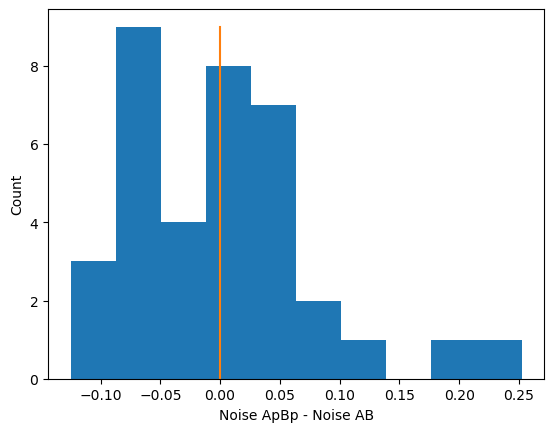

In [26]:
est_diff = indiv_model_apbp.noise - indiv_model_ab.noise
plt.hist(est_diff)
plt.plot((0, 0), (0, 9), scaley = False)
plt.xlabel("Noise ApBp - Noise AB")
plt.ylabel("Count")
plt.show()